# FDCT: NumPy (fp64) vs JAX (fp32) Comparison

This notebook compares the performance and accuracy of the Forward Discrete Curvelet Transform (FDCT) implemented in NumPy (double precision) and JAX (single precision).

In [ ]:
# Install the package (Uncomment if running on Colab)
# !pip install git+https://github.com/Forgotten/fast_curvelet_transform.git

import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from skimage import data
import time
from fast_curvelet_transform.curvelet import fdct_wrapping, ifdct_wrapping
from fast_curvelet_transform.curvelet_jax import fdct_wrapping_jax

# Explicitly disable x64 for this example.
jax.config.update("jax_enable_x64", False)

print(f"JAX x64 enabled: {jax.config.read('jax_enable_x64')}")

JAX x64 enabled: False


## 1. Load Data and Parameters

In [ ]:
# Load image.
image = data.camera().astype(np.float64)
n1, n2 = image.shape
print(f"Loaded image of size {n1}x{n2}")

# Parameters.
is_real = True
finest = "wavelets"
nbscales = 5
nbangles_coarse = 16

Loaded image of size 512x512


## 2. Benchmark NumPy (Double Precision)

In [3]:
print("[NumPy Double] Benchmarking forward transform (5 trials)...")
np_times = []
for i in range(5):
    start_np = time.time()
    coeffs_np = fdct_wrapping(
        image, is_real=is_real, finest=finest, nbscales=nbscales, nbangles_coarse=nbangles_coarse
    )
    np_times.append(time.time() - start_np)

print(f"NumPy Mean: {np.mean(np_times):.4f}s, Variance: {np.var(np_times):.2e}s")

[NumPy Double] Benchmarking forward transform (5 trials)...
NumPy Mean: 0.0377s, Variance: 8.54e-07s


## 3. Benchmark JAX (Single Precision)

In [4]:
print("[JAX Single] Computing first call (including JIT)...")
image_jax = jnp.array(image.astype(np.float32))
print(f"JAX Input Dtype: {image_jax.dtype}")

start_jax = time.time()
coeffs_jax = fdct_wrapping_jax(
    image_jax,
    is_real=is_real,
    finest=finest,
    nbscales=nbscales,
    nbangles_coarse=nbangles_coarse
)
jax.block_until_ready(coeffs_jax)
print(f"JAX First Call took: {time.time() - start_jax:.4f}s")

print("\n[JAX Single] Benchmarking warm forward transform (5 trials)...")
jax_times = []
for i in range(5):
    start_jax = time.time()
    coeffs_jax = fdct_wrapping_jax(
        image_jax,
        is_real=is_real,
        finest=finest,
        nbscales=nbscales,
        nbangles_coarse=nbangles_coarse
    )
    jax.block_until_ready(coeffs_jax)
    jax_times.append(time.time() - start_jax)

print(f"JAX Warm Mean: {np.mean(jax_times):.4f}s, Variance: {np.var(jax_times):.2e}s")

[JAX Single] Computing first call (including JIT)...
JAX Input Dtype: float32
JAX First Call took: 1.5407s

[JAX Single] Benchmarking warm forward transform (5 trials)...
JAX Warm Mean: 0.0105s, Variance: 2.07e-08s


## 4. Verification and Visualization

Maximum difference in coefficients: 1.32e-02
Reconstruction error (NP Double coeffs): 4.43e-16
Reconstruction error (JAX Single coeffs): 1.30e-07


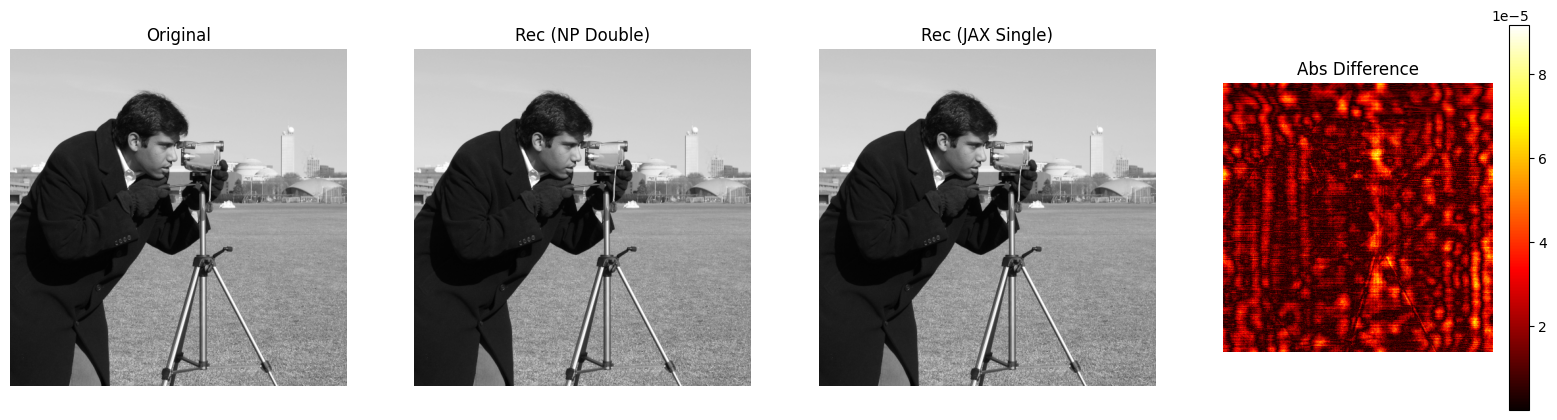

In [ ]:
# Compare coefficients.
max_diff_coeffs = 0
for j in range(len(coeffs_np)):
    for l in range(len(coeffs_np[j])):
        diff = np.abs(coeffs_np[j][l] - np.array(coeffs_jax[j][l]))
        max_diff_coeffs = max(max_diff_coeffs, np.max(diff))
print(f"Maximum difference in coefficients: {max_diff_coeffs:.2e}")

# Inverse transform with the NumPy version (on both coefficients)
rec_np = ifdct_wrapping(coeffs_np, is_real=is_real, m_img=n1, n_img=n2)

coeffs_jax_np = [
    [np.array(c).astype(np.complex128) for c in scale] for scale in coeffs_jax
    ]
rec_jax = ifdct_wrapping(coeffs_jax_np, is_real=is_real, m_img=n1, n_img=n2)

# Errors.
error_np = np.linalg.norm(image - rec_np) / np.linalg.norm(image)
error_jax = np.linalg.norm(image - rec_jax) / np.linalg.norm(image)
print(f"Reconstruction error (NP Double coeffs): {error_np:.2e}")
print(f"Reconstruction error (JAX Single coeffs): {error_jax:.2e}")

# Visualization.
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
axes[0].imshow(np.real(image), cmap='gray')
axes[0].set_title("Original")
axes[0].axis('off')

axes[1].imshow(np.real(rec_np), cmap='gray')
axes[1].set_title("Rec (NP fp64)")
axes[1].axis('off')

axes[2].imshow(np.real(rec_jax), cmap='gray')
axes[2].set_title("Rec (JAX fp32)")
axes[2].axis('off')

diff_map = np.abs(np.real(rec_np) - np.real(rec_jax))
im = axes[3].imshow(diff_map, cmap='hot')
axes[3].set_title("Abs Difference")
axes[3].axis('off')
plt.colorbar(im, ax=axes[3])
plt.show()